In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import os

In [72]:
def find_pareto_front_hyperidx(x:np.ndarray, y:np.ndarray)->list[int]:
    paretof_hyper_idxs = []
    
    i = np.argmin(y)
    
    paretof_hyper_idxs.append(i)
    
    while np.any(x < x[i]):
        print(np.any(x < x[i]))
        idx = np.argwhere(x < x[i])
        # len(idx)
        # print(y[idx])
        i0 = np.argmin(y[idx])
        # print(i0)
        
        
        i = idx[i0]
        
        # print(idx)
        # print(i0)
        # print(i)
        paretof_hyper_idxs.append(i)
    
    
    return paretof_hyper_idxs

In [67]:
def make_pareto_frontier_plot(results: pd.DataFrame, h: list[int], metric: str, title:str, 
                              alpha: int=1, 
                              log_scale: bool=False, 
                              add_oracle_NRMSE_line: bool=False, 
                              fve: float=np.nan)-> tuple[ggplot, list[int]]:
    results = results[results["h"].isin(h)].copy()
    results = results.groupby(["hyper_idx"]).agg(
        mean_squared_error=("squared_error", "mean"), 
        RMSE=("squared_error", lambda x: np.sqrt(x.mean())), 
        coverage_accuracy=("coverage_flags", "mean"), 
        flops =("flops", "mean"), 
        num_params = ("num_params", "mean"), 
        sd = ("sd", "mean")
    )
    results["normalized_rmse"] = results["RMSE"] / results["sd"]
    results.reset_index(drop=False, inplace=True)
    # print(results)
    boundary_idxs = find_pareto_front_hyperidx(results[metric].values, results["normalized_rmse"].values)
    results["boundary_flag"] = results["hyper_idx"].isin(boundary_idxs)
    
    if metric == "flops":
        
        plot = (
            ggplot(results, aes(x=metric,y="normalized_rmse")) + 
            geom_point(alpha = alpha) +
            geom_point(results[results["boundary_flag"]], color="red") + 
            labs(
                x = "Flops (K)", 
                y = "Normalized RMSE", 
                title=title
            ) + 
            theme_bw()
        )
    else:
        plot = (
            ggplot(results, aes(x=metric,y="normalized_rmse")) + 
            geom_point(alpha = alpha) + 
            geom_point(results[results["boundary_flag"]], color="red") + 
            labs(
                x = "Number of Parameters (K)", 
                y = "Normalized RMSE", 
                title=title
            ) + 
            theme_bw()
        )
    
    if log_scale:
        plot = plot + scale_x_log10()
    
    if add_oracle_NRMSE_line:
        plot = plot + geom_hline(yintercept = np.sqrt(1-fve**np.min(h)), linetype="dashed")
    boundary_idxs = []
    
    
    return plot, boundary_idxs

In [68]:
wd = os.getcwd()
datapath = os.path.join(wd, "results_GL")
os.listdir(datapath)

['power', 'exp']

## Exp Results

In [69]:
exp_path = os.path.join(datapath, "exp")


In [70]:
dataframes_exp = {}
for dir in os.listdir(exp_path):
    exp_data = os.path.join(exp_path, dir)
    
    theta_val = exp_data.split(os.sep)[-1].split("_")[3]
    
    data = os.path.join(exp_data, "results.parquet")
    df = pd.read_parquet(data)
    
    dataframes_exp[theta_val] = df

    

True
True
True
True
True
True
True
True


/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 721 rows containing missing values.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


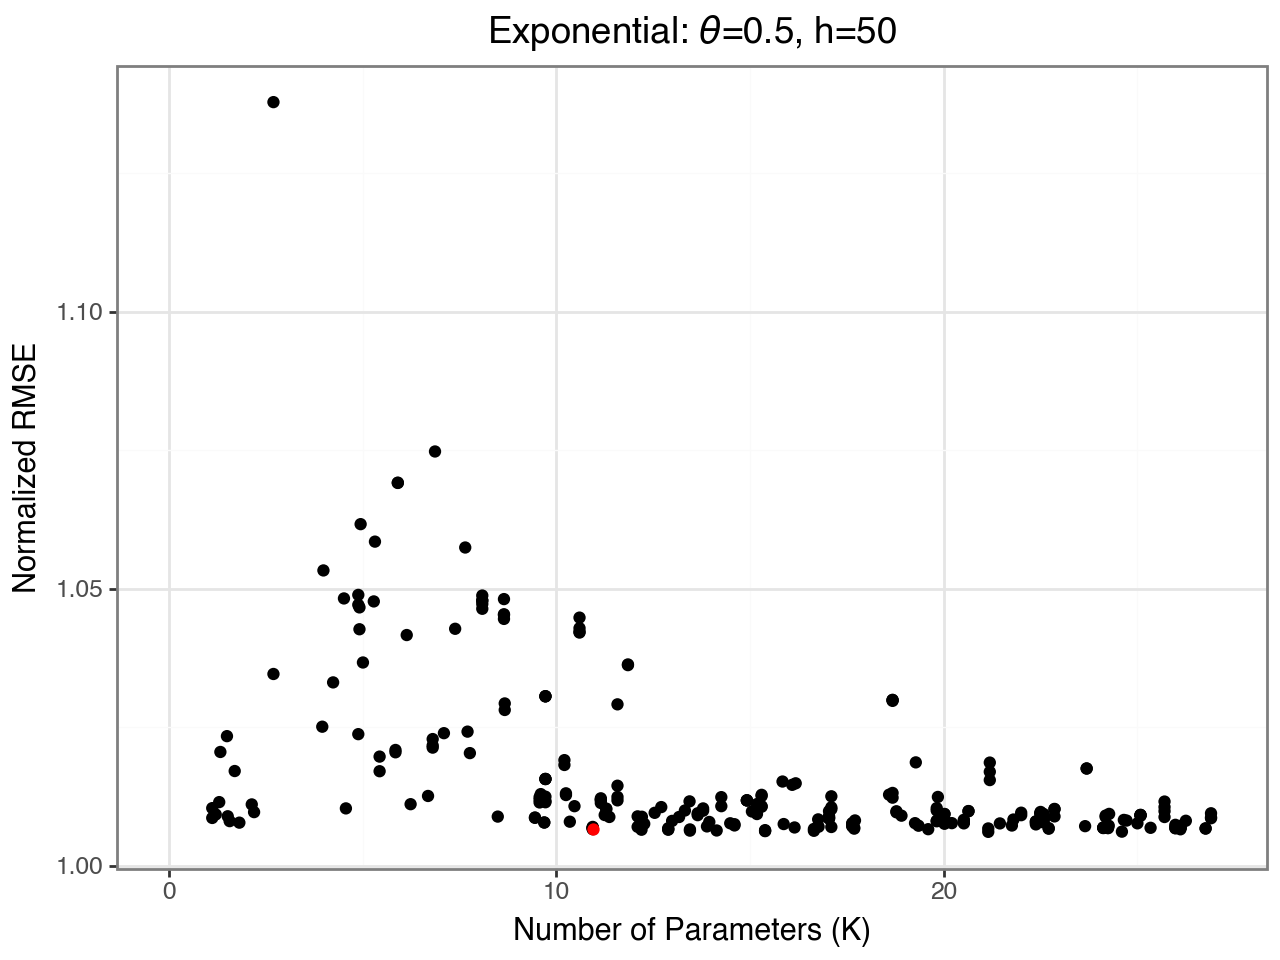

True
True
True
True
True
True
True
True
True
True
True


/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 721 rows containing missing values.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


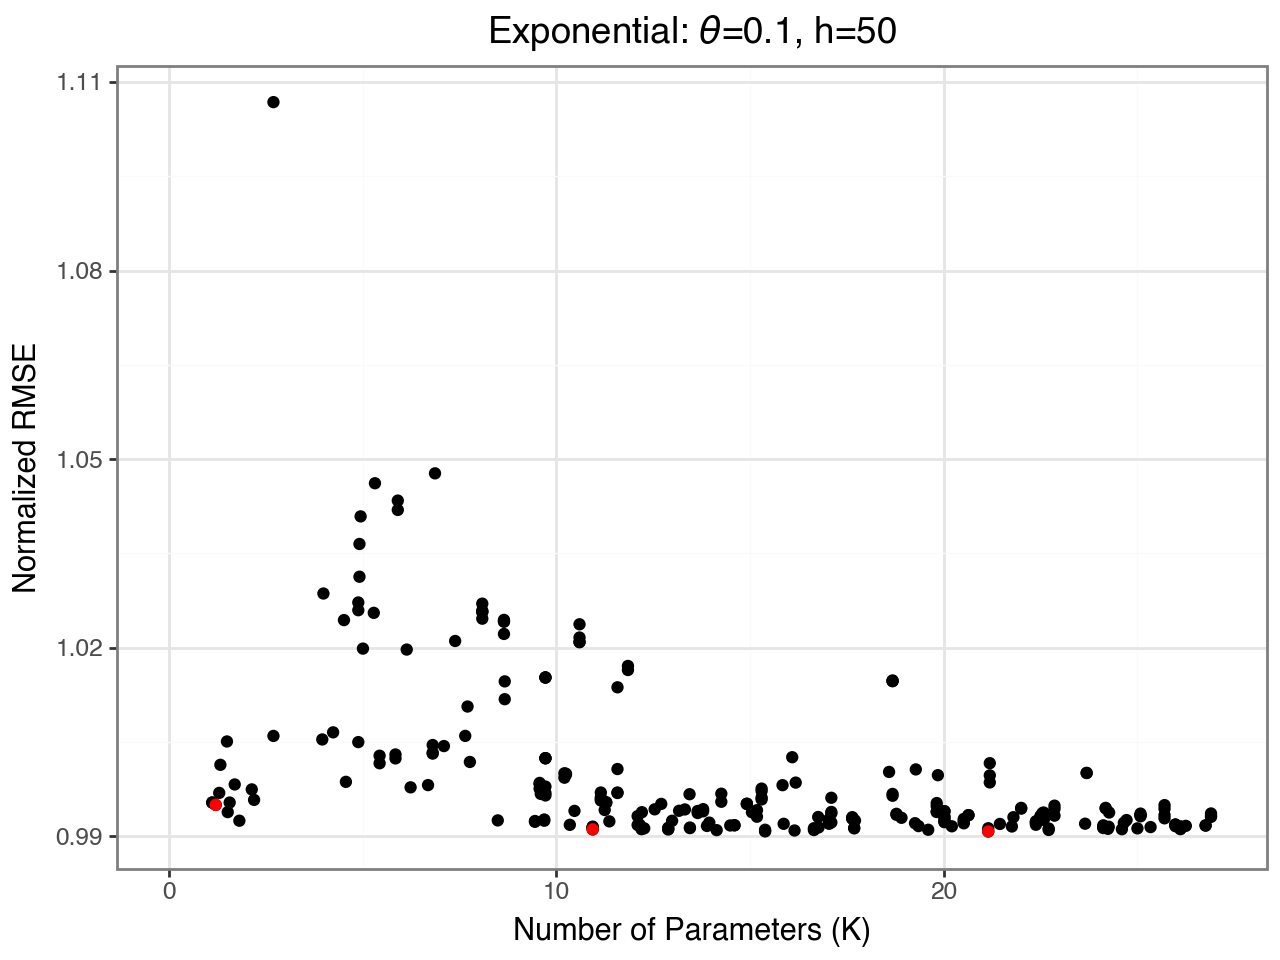

In [71]:
for key in dataframes_exp.keys():
    results = dataframes_exp[key]
    title = rf"Exponential: $\theta$={key}, h=50"
    plot, _ = make_pareto_frontier_plot(results, list(range(50,61)), metric="num_params", title=title, log_scale=False, alpha=1)
    plot = plot + xlim(0,27)
    plot.show()

## Power Results

In [8]:
power_path = os.path.join(datapath, "power")

In [9]:
dataframes = []
for dir in os.listdir(power_path):
    
    power_data = os.path.join(power_path, dir)
    gamma_val = power_data.split(os.sep)[-1].split("_")[3]
    data = os.path.join(power_data, "results.parquet")
    df = pd.read_parquet(data)
    dataframes.append(df)
    # print(df)

In [10]:
power_df = pd.concat(dataframes)
power_df

,hyper_idx,h,observed,prediction,lower_bound,upper_bound,coverage_flags,squared_error,pred_length,flops,num_params,sd,runtime
0,0,1,-0.276006,0.078330,-4.086105,4.242766,True,0.125554,8.328872,157.84,40.38,1.663564,PatchTST
1,0,2,-1.084446,0.062972,-3.941568,4.067514,True,1.316568,8.009082,157.84,40.38,1.663564,PatchTST
2,0,3,-1.466679,0.009556,-3.830426,3.849540,True,2.179270,7.679967,157.84,40.38,1.663564,PatchTST
3,0,4,1.204994,0.071791,-3.683050,3.826635,True,1.284149,7.509685,157.84,40.38,1.663564,PatchTST
4,0,5,2.402607,0.060702,-4.088705,4.210112,True,5.484519,8.298817,157.84,40.38,1.663564,PatchTST
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,999,96,-1.253841,0.227360,-4.451764,4.906485,True,2.193957,9.358249,357.34,68.28,1.663564,PatchTST
9999996,999,97,-0.920393,0.069900,-4.589016,4.728818,True,0.980678,9.317834,357.34,68.28,1.663564,PatchTST
9999997,999,98,-0.036630,0.175046,-3.937499,4.287592,True,0.044806,8.225090,357.34,68.28,1.663564,PatchTST
9999998,999,99,1.241308,0.200388,-4.090617,4.491394,True,1.083515,8.582011,357.34,68.28,1.663564,PatchTST


True
True
True
True
True
True
True
True


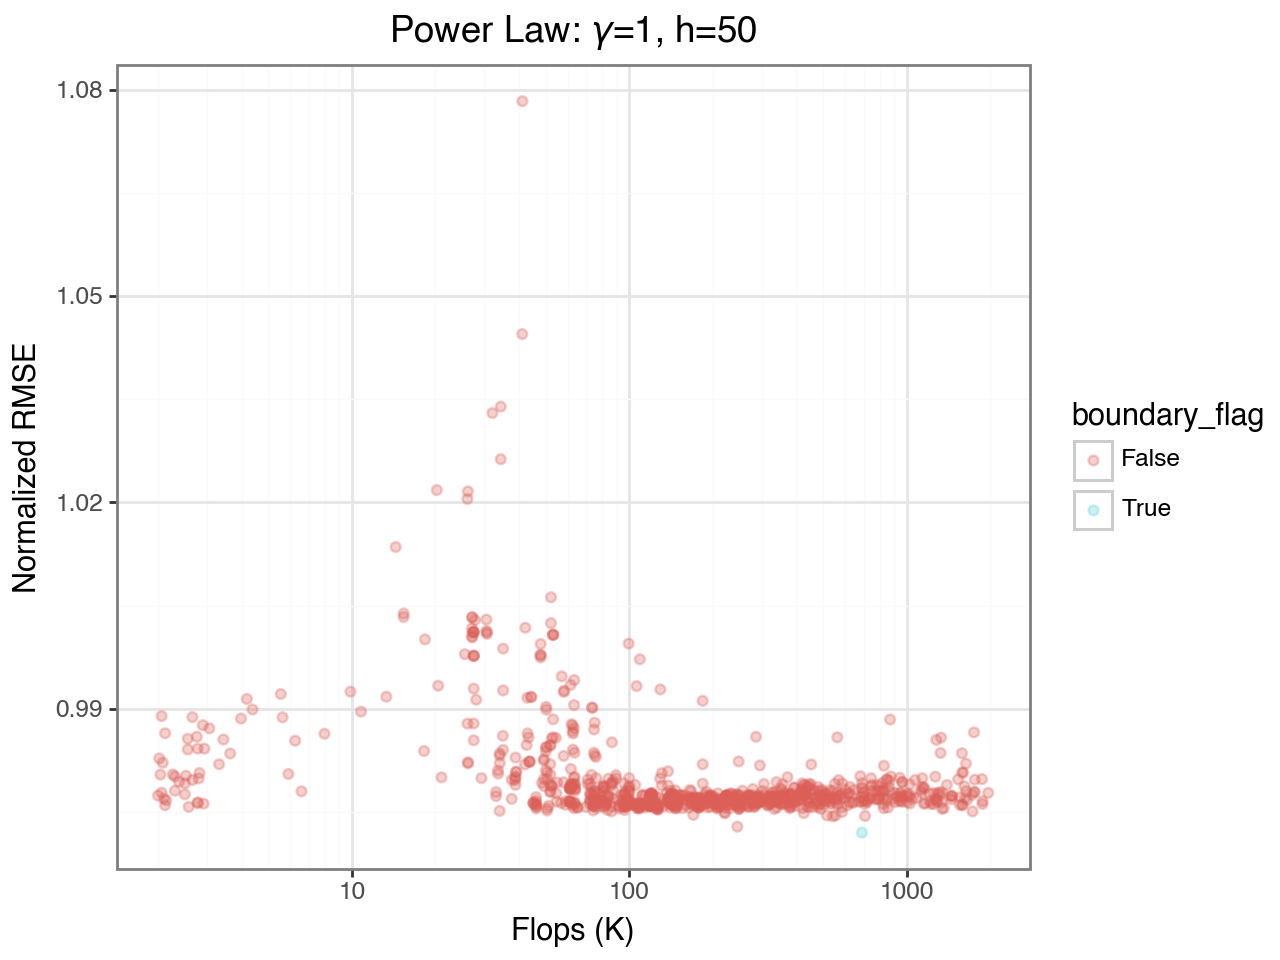

In [53]:
plot, l = make_pareto_frontier_plot(power_df, list(range(50,61)), "flops", r"Power Law: $\gamma$=1, h=50", alpha=0.3, log_scale=True)
plot

True
True
True
True
True
True
True


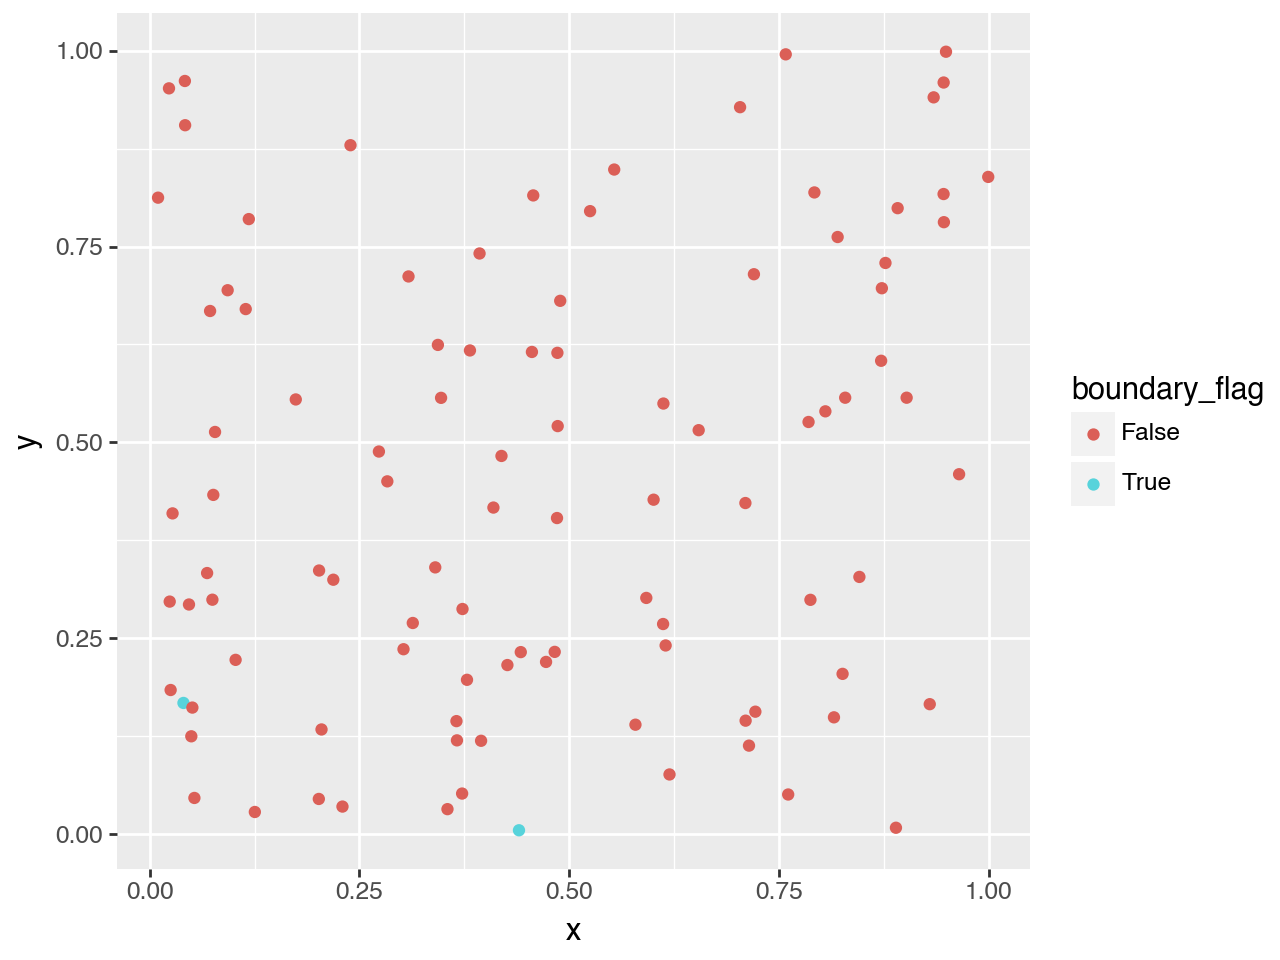

In [75]:
x = np.random.uniform(0, 1, size=100)
y = np.random.uniform(0, 1, size=100)
idx = find_pareto_front_hyperidx(x, y)

df = pd.DataFrame({"x": x, "y":y})
df.reset_index(drop=False, inplace=True, names="i")
df["boundary_flag"] = df["i"].isin(idx)
(
    ggplot(df, aes(x="x", y="y", color = "boundary_flag")) + 
    geom_point()
)
    